In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join
from scipy import stats


import sys
sys.path.append('..')
import src as tools

## 1.  Set up Envoronment 

If you had trouble with with imports above, check that you have all of the necessary requirements installed by running 
```
pip install -U -r requirements.txt
```
and if you plan to carry out the OCR step
```
pip install -U -r requirements_ocr.txt
```
in the command line from the top level git directory.

## 2. (Optional) Parse and Process Data

This assumes you already have the necessary parquet files. If you don't have them, then you need to carry out the OCR work which can be done from the command line from the top level git directory by running 
```
cd scripts
python pdf_to_parquet.py 2019
python pdf_to_parquet.py 2020
```
Warning, this OCR process will take several hours.  

If you have the parquet files, then you can proceed as follows.

In [2]:
for year in [2019,2020]:
    
    # Read available parquet files.
    my_path = f"{tools.PROJECT_FOLDER}/data/{year}_parquet_logs"
    files = [f for f in listdir(my_path) if isfile(join(my_path, f))]
    files.sort()

    df_parquet = pd.DataFrame()
    for f in files:
        df_parquet = pd.concat([df_parquet,pd.read_parquet(f"{my_path}/{f}")])

    df_parquet.reset_index(drop = True, inplace = True)

    df = tools.parse_ocr_output(df_parquet, year)
    filepath = f"{tools.PROJECT_FOLDER}/data/parsed_{year}_logs.csv"
    df.to_csv(filepath)
    print(f"Data printed to {filepath}")

Data printed to /home/anna/Dropbox/research/qsideinstitute/SToPA/data/parsed_2019_logs.csv
Data printed to /home/anna/Dropbox/research/qsideinstitute/SToPA/data/parsed_2020_logs.csv


The code above can also be carried from the command line by running the following from the top level git directory

```
cd scripts
python parquet_to_csv.py 2019
python parquet_to_csv.py 2020
```
This should only take a few minutes.

## 3. Load Data

Now we can load the data and begin exploring data features and quality.

In [3]:
df_2019 = pd.read_csv(f"{tools.PROJECT_FOLDER}/data/parsed_2019_logs.csv", index_col = 0)
df_2020 = pd.read_csv(f"{tools.PROJECT_FOLDER}/data/parsed_2020_logs.csv", index_col = 0)

In [4]:
df = pd.concat([df_2019, df_2020])
df.reset_index(drop = True, inplace = True)

for col in df.columns:
    if "date" in col:
        df[col] = pd.to_datetime(df[col])
        
df.head()

,date,change_idx,log_num,pdf_page,call_datetime,disp_datetime,enrt_datetime,arvd_datetime,clrd_datetime,call_reason,call_type,call_action,call_taker,responding_units,street
0,2019-01-01,12,19-1,1,2019-01-01 03:41:00,NaT,NaT,2019-01-01 03:42:00,2019-01-01 03:42:17,PARKING CHECK,Initiated,SERVICES RENDERED,PATROL CRAIG A EICHHAMMER,31,NORTH STREET
1,2019-01-01,35,19-4,1,2019-01-01 08:34:00,NaT,NaT,NaT,2019-01-01 08:35:33,BUILDING CHECK,Other,BUILDING CHECKED/SECURED,"PATROL DAVID JENNINGS, D",34,COLD SPRING ROAD
2,2019-01-01,64,19-5,1,2019-01-01 08:42:00,NaT,NaT,NaT,2019-01-01 08:43:21,BUILDING CHECK,Other,BUILDING CHECKED/SECURED,"PATROL DAVID JENNINGS, D",34,LONGVIEW TERRACE
3,2019-01-01,90,19-6,1,2019-01-01 08:46:00,NaT,NaT,NaT,2019-01-01 08:47:07,BUILDING CHECK,Other,BUILDING CHECKED/SECURED,"PATROL DAVID JENNINGS, D",34,FRENIER AVENUE
4,2019-01-01,116,19-7,1,2019-01-01 08:47:00,NaT,NaT,NaT,2019-01-01 08:48:05,BUILDING CHECK,Other,BUILDING CHECKED/SECURED,"PATROL DAVID JENNINGS, D",34,HARWOOD STREET


## Verify Data Quality

In [5]:
df.count()/df.shape[0]*100

date                100.000000
change_idx          100.000000
log_num             100.000000
pdf_page            100.000000
call_datetime        90.124703
disp_datetime        18.528803
enrt_datetime        13.863786
arvd_datetime        65.951431
clrd_datetime        74.201040
call_reason         100.000000
call_type           100.000000
call_action         100.000000
call_taker          100.000000
responding_units     82.788913
street              100.000000
dtype: float64

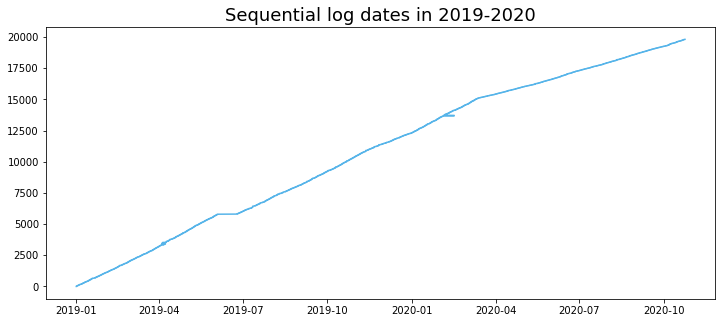

In [6]:
fig, ax = plt.subplots(figsize = (12,5))
ax.plot(pd.to_datetime(df["date"]).values, df.index, color = "#56B4E9")
ax.set_xticks = pd.date_range("2019-01-01","2021-01-01", freq = "M")
ax.set_title("Sequential log dates in 2019-2020", fontsize = 18)
plt.show()

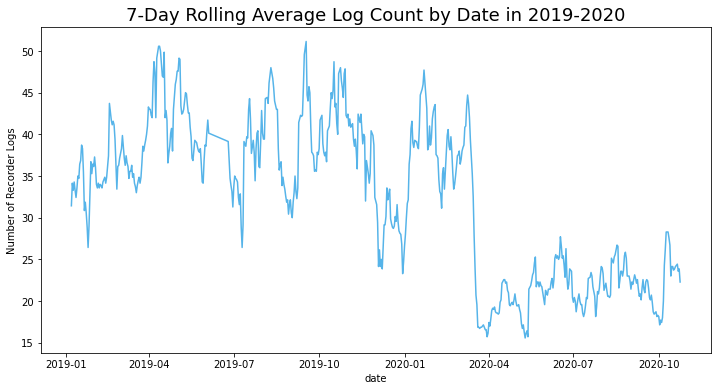

In [7]:
date_series = pd.Series(df["date"].value_counts())
date_series.sort_index(inplace = True)

height = date_series.rolling(window = 7).mean().values
x = date_series.rolling(window = 7).mean().index

fig, ax = plt.subplots(figsize = (12,6))
ax.plot(x, height, color = "#56B4E9")
ax.set_xlabel("date")
ax.set_ylabel("Number of Recorder Logs")

plt.title("7-Day Rolling Average Log Count by Date in 2019-2020", fontsize = 18)
plt.show()

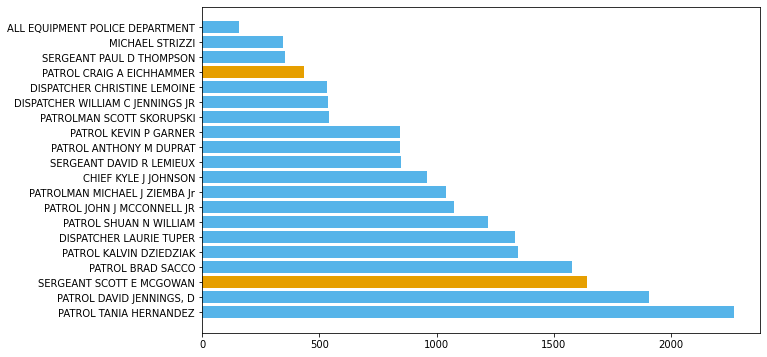

In [9]:
cats = df["call_taker"].value_counts().to_dict()
fig, ax = plt.subplots(figsize = (10,6))


c = ["#56B4E9" if not c in ['PATROL CRAIG A EICHHAMMER','SERGEANT SCOTT E MCGOWAN'] else "#E69F00" for c in cats.keys()]
ax.barh(y = list(cats.keys()), width = list(cats.values()), color = c)

plt.show()

## Validation Function

You'll need the OCR tools to do this.  This just prints a random log and the associated parsed entry for a visual sanity check.

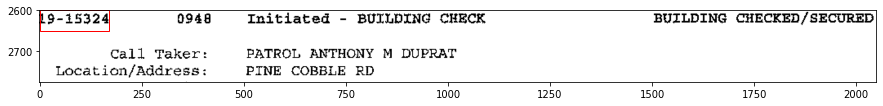

,date,change_idx,log_num,pdf_page,call_datetime,disp_datetime,enrt_datetime,arvd_datetime,clrd_datetime,call_reason,call_type,call_action,call_taker,responding_units,street
11708,2019-12-11,557416,19-15324,2257,NaT,NaT,NaT,NaT,NaT,BUILDING CHECK,Other,BUILDING CHECKED/SECURED,PATROL ANTHONY M DUPRAT,34,PINE COBBLE ROAD


In [10]:
tools.confirm_parsed_log_entry(df, entry_index = None)